<a href="https://colab.research.google.com/github/ZohebAbai/DeepLearning-Projects/blob/master/MNIST_Classification_using_FC_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exploring the data

`torchvision` contains some utilities for working with image data. It also contains helper classes to automatically download and import popular datasets like MNIST.

In [0]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
dataset = MNIST(root='data/', download=True)

0it [00:00, ?it/s]

9920512it [00:02, 4550951.76it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 67503.97it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1128388.18it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25641.25it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
len(dataset)

60000

The dataset has 60,000 images which can be used to train the model. There is also an additional test set of 10,000 images which can be created by passing train=False to the MNIST class.

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Label: 5


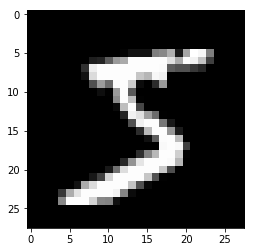

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [0]:
import torchvision.transforms as transforms

`torchvision.transforms` contains many such predefined functions, and we'll use the ToTensor transform to convert images into PyTorch tensors.

In [0]:
dataset = MNIST(root='data/', train=True, 
                transform=transforms.ToTensor())

In [8]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [9]:
print(torch.max(img_tensor), torch.min(img_tensor))

tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white and the values in between different shades of grey. 

### Splitting the datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

* Training set — used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
* Validation set — used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
* Test set — used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In the MNIST dataset, there are 60,000 training images, and 10,000 test images. The test set is standardized so that different researchers can report the results of their models against the same set of images. Since there’s no predefined validation set, we must manually split the 60,000 images into training and validation datasets.

In [0]:
import numpy as np

def split_indices(n, val_pct):
  
  #determine the size of validation set
  n_val = int(val_pct*n)
  
  #create random permutation of 0 to n-1
  idxs = np.random.permutation(n)
  
  #pick first n_val indices for validation set
  return idxs[n_val:], idxs[:n_val]

`split_indices` randomly shuffles the array indices 0,1,..n-1, and separates out a desired portion from it for the validation set. It's important to shuffle the indices before creating a validation set, because the training images are often ordered by the target labels i.e. images of 0s, followed by images of 1s, followed by images of 2s and so on. If we were to pick a 20% validation set simply by selecting the last 20% of the images, the validation set would only consist of images of 8s and 9s, whereas the training set would contain no images of 8s and 9s. This would make it impossible to train a good model using the training set, which also performs well on the validation set (and on real world data).

In [11]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.20)
print(len(train_indices), len(val_indices))

48000 12000


We can now create PyTorch data loaders for each of these using a `SubsetRandomSampler`, which samples elements randomly from a given list of indices, while creating batches of data.

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [0]:
batch_size=64

#Training sampler and dataloader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size,sampler= train_sampler)

#Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler= val_sampler)


### Build the model

For a **logistic regression** model, nn.Linear expects the each training example to be a vector, each 1x28x28 image tensor needs to be flattened out into a vector of size 784 (28*28), before being passed into the model.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

input_size= 28*28
num_classes = 10

class MnistModel(nn.Module):
  """Feedforward NN with 1 hidden layer"""
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    
    #Hidden Layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    
    #Output Layer
    self.linear2 = nn.Linear(hidden_size, out_size)
    
  def forward(self, xb):
    #Flatten the image tensors
    xb = xb.view(xb.size(0), -1)
    
    #Get intermediate outputs using hidden layers 
    out = self.linear1(xb)
    
    #Apply activation function
    out = F.relu(out)
    
    #Get predictions using output layer
    out = self.linear2(out)
    
    return out

#model = MnistModel()
#print(model.linear.weight.shape, model.linear.bias.shape)

### Using GPU

In [0]:
def get_default_device():
  """Pick GPUif available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [0]:
device = get_default_device()

In [0]:
def to_device(data, device):
  """Move tensors to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [0]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
    
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
      
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [0]:
#Wrap the data loader using DeviceDataLoader
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

### Train the model

We need to define the accuracy to operate on an entire batch of outputs directly, so that we can use it as a metric in `fit`.

In [0]:
def accuracy(outputs, labels):
  #determine the predicted label for each image by simply choosing 
  #the index of the element with the highest probability in each output row.
  _,preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

While the `accuracy` is a great way for us (humans) to evaluate the model, it can’t be used as a loss function for optimizing our model using gradient descent, for the following reasons:

* It’s not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.
* It doesn’t take into account the actual probabilities predicted by the model, so it can’t provide sufficient feedback for incremental improvements.

Unlike `accuracy`, `cross-entropy` is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function. It also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

Cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples.

In [0]:
# Loss function
loss_fn = F.cross_entropy

We define a function loss_batch which:

* calculates the loss for a batch of data
* optionally perform the gradient descent update step if an optimizer is provided
* optionally computes a metric (e.g. accuracy) using the predictions and actual targets


In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
  
  #Calculate loss
  preds = model(xb)
  loss = loss_func(preds, yb)
  
  if opt is not None:
    #Compute gradients
    loss.backward()
    #Update parameters
    opt.step()
    #Reset gradients
    opt.zero_grad()
    
  metric_result = None
  if metric is not None:
    #compute metric
    metric_result = metric(preds, yb)
      
  return loss.item(), len(xb), metric_result 

The optimizer is an optional argument, to ensure that we can reuse `loss_batch` for computing the loss on the validation set. We also return the length of the batch as part of the result, as it'll be useful while combining the losses/metrics for the entire dataset.

Next we define a function evaluate, which calculates the overall loss (and a metric, if provided) for the validation set.

In [0]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad():
    
    #Pass each batch through the model
    results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
    
    #Separate losses, counts and metrics
    losses, nums, metrics = zip(*results)
    
    #Total size of dataset
    total = np.sum(nums)
    
    #Avg. loss across batches
    avg_loss = np.sum(np.multiply(losses, nums)) / total
    avg_metric = None
    if metric is not None:
      #avg of metric across batches
      avg_metric = np.sum(np.multiply(metrics, nums)) / total
  
  return avg_loss, total, avg_metric

Let's define the `fit` function using loss_batch and evaluate.

In [0]:
def fit(epochs, lr, model, loss_fn, train_dl, 
        valid_dl, metric=None, opt_fn=None):
  
  losses, metrics = [],[]
  
  #Instantiate the optimizer
  if opt_fn is None: opt_fn = torch.optim.Adam
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  
  for epoch in range(epochs):
    #Training
    for xb, yb in train_dl:
      loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
      
    #Evaluation
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result
    
    #Record the loss and metric
    losses.append(val_loss)
    metrics.append(val_metric)
    
    #Print progress
    if metric is None:
      print('Epoch [{}/{}], Loss: {:.4f}'.format
           (epoch+1, epochs, val_loss))
    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format
           (epoch+1, epochs, val_loss, metric.__name__, val_metric))
      
  return losses, metrics

In [25]:
#Lets train the model
model = MnistModel(input_size, hidden_size=128, out_size=num_classes)
to_device(model, device)

#Fit
losses, metrics = fit(20, 0.001, model, loss_fn, train_dl, valid_dl, metric=accuracy)

Epoch [1/20], Loss: 0.2103, accuracy: 0.9388
Epoch [2/20], Loss: 0.1512, accuracy: 0.9564
Epoch [3/20], Loss: 0.1168, accuracy: 0.9654
Epoch [4/20], Loss: 0.0986, accuracy: 0.9708
Epoch [5/20], Loss: 0.0919, accuracy: 0.9727
Epoch [6/20], Loss: 0.0817, accuracy: 0.9758
Epoch [7/20], Loss: 0.0738, accuracy: 0.9773
Epoch [8/20], Loss: 0.0761, accuracy: 0.9767
Epoch [9/20], Loss: 0.0720, accuracy: 0.9771
Epoch [10/20], Loss: 0.0740, accuracy: 0.9786
Epoch [11/20], Loss: 0.0735, accuracy: 0.9781
Epoch [12/20], Loss: 0.0748, accuracy: 0.9782
Epoch [13/20], Loss: 0.0781, accuracy: 0.9772
Epoch [14/20], Loss: 0.0799, accuracy: 0.9774
Epoch [15/20], Loss: 0.0808, accuracy: 0.9782
Epoch [16/20], Loss: 0.0800, accuracy: 0.9788
Epoch [17/20], Loss: 0.0806, accuracy: 0.9780
Epoch [18/20], Loss: 0.0825, accuracy: 0.9793
Epoch [19/20], Loss: 0.0833, accuracy: 0.9773
Epoch [20/20], Loss: 0.0826, accuracy: 0.9797


Parameters like batch size, learning rate etc. need to picked in advance while training machine learning models, and are called hyperparameters. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time, and is an active area of research and experimentation.

### Visualization

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

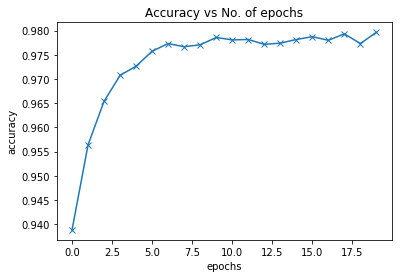

In [26]:
plt.plot(metrics, '-x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')

### Test the model

In [0]:
#convert test image dataset to pytorch tensors
test_dataset = MNIST(root='data/', train=False, 
                     transform=transforms.ToTensor())


Let’s also look at the overall loss and accuracy of the model on the test set.


In [28]:
test_loader = DataLoader(test_dataset, batch_size=64)
test_dl = DeviceDataLoader(test_loader, device)

test_loss, total, test_acc = evaluate(model, loss_fn, test_dl,
                                     metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format
     (test_loss, test_acc))

Loss: 0.0913, Accuracy: 0.9772


### Save the Model

In [0]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

### Load the Model

In [0]:
model2 = MnistModel(input_size, hidden_size=128, out_size=num_classes)
model2.load_state_dict(torch.load('mnist-logistic.pth'))